### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import textstat
import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib.ticker as ticker 
import seaborn as sns
import datetime
import re
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.style.use('seaborn')

# Data loading and Cleaning

In [2]:
# Declare global variables
lecturePatt = re.compile(r'w\d\s([A-Za-z\s]+)')
timePatt = re.compile(r'(\d{2}:\d{2}:\d{2}\.\d{0,3})')
lectPatt = re.compile(r'([A-Za-z,]+)')
lectTime = re.compile(r'\d{2}:\d{2}:\d{2}\.\d{3}')
sentPatt = re.compile(r'(?P<time>\d{2}:\d{2}:\d{2}\.\d{0,3}\s-->\s\d{2}:\d{2}:\d{2}\.\d{0,3})\n(?P<content>[A-Za-z,\'\s\n\.]+)')
filePath = "data/"

def load_data(path):
    '''
    Get the path of the vtt files and load the data, generate the fragments, sentence and lecture dataframe
    '''
    fragments_df = get_fragments(path)
    lect_df = get_lectures(path)
    sent_df = get_sentences(path)

    df = pd.concat([fragments_df, sent_df, lect_df])
    df = fk_score(df)

    # Rearrange the columns
    cols = ['text', 'time_start', 'time_end', 'fk_score', 'granularity', 'lecture']
    df = df[cols]
    df['time_start'] = pd.to_datetime(df['time_start'])
    df = df.set_index('time_start')
    return(df)

# Getting all the fragments
def get_fragments(path):
    '''
    create the dataframe for all the fragments in the data
    '''
    files = os.listdir(path)
    text, time_start,time_end, granularity, lecture = [], [], [], [], []
    for file in files:
        if file.endswith('.vtt'):
            lectName = re.findall(r'w\d\s([A-Za-z\s]+)', file)[0]
            filepath = path + file
            with open(filepath, 'r') as file:
                content = file.read()
                i = 0
                for m in sentPatt.finditer(content):
                    i += 1
                    timePeriod = timePatt.findall(m.group('time'))
                    start_time = timePeriod[0]
                    end_time = timePeriod[-1]
                    sentGroup =    m.group('content')
                    if(re.search('\n', sentGroup)):
                        newLinesMat = re.search('\n', sentGroup)
                        if((newLinesMat.span()[1]) < len(sentGroup)):
                            sentGroup = sentGroup.replace('\n', ' ')
                        else:
                            sentGroup = sentGroup.replace('\n', '')
                    text.append(sentGroup.strip())
                    time_start.append(start_time)            
                    time_end.append(end_time)
                    granularity.append('fragment') 
                    lecture.append(lectName)     
            df = pd.DataFrame(list(zip(text, time_start, time_end, granularity, lecture)), 
                columns=['text', 'time_start', 'time_end', 'granularity', 'lecture'])                      
    return(df)

def get_lectures(path):   
    '''
    create the dataframe for all the lectures in the data
    '''    
    files = os.listdir(path)
    text, time_start,time_end, granularity, lecture = [], [], [], [], []
    for file in files:
        if file.endswith('.vtt'):
            lectName = re.findall(r'w\d\s([A-Za-z\s]+)', file)[0]
            filepath = path + file
            with open(filepath, 'r') as file:
                content = file.read()
                i = 0
                sentence = ''
                for m in sentPatt.finditer(content):
                    i += 1
                    if  sentence == '':
                        startTime = timePatt.findall(m.group('time'))
                        start_time = startTime[0]

                    sentGroup =    m.group('content')
                    if(re.search('\n', sentGroup)):
                        newLinesMat = re.search('\n', sentGroup)
                        if((newLinesMat.span()[1]) < len(sentGroup)):
                            sentGroup = sentGroup.replace('\n', ' ')
                        else:
                            sentGroup = sentGroup.replace('\n', '')
                    sentence = sentence  + ' ' + sentGroup.strip()

                #Make a full lecture
                text.append(sentence.lstrip())
                time_start.append(start_time)            
                endTimeMatch = timePatt.findall(m.group('time'))
                time_end.append(endTimeMatch[-1])
                granularity.append('lecture') 
                lecture.append(lectName)     

    df = pd.DataFrame(list(zip(text, time_start, time_end, granularity, lecture)), 
        columns=['text', 'time_start', 'time_end', 'granularity', 'lecture'])   
    return(df)


# Getting all the sentences
def get_sentences(path):
    '''
    create the dataframe for all the sentences in the data
    '''    
    files = os.listdir(path)
    text, time_start,time_end, granularity, lecture = [], [], [], [], []
    for file in files:
        if file.endswith('.vtt'):
            lectName = re.findall(r'w\d\s([A-Za-z\s]+)', file)[0]
            filepath = path + file            
            with open(filepath, 'r') as file:
                content = file.read()
                i = 0
                sentence = ''
                for m in sentPatt.finditer(content):
                    i += 1
                    if  sentence == '':
                        startTime = timePatt.findall(m.group('time'))
                        start_time = startTime[0]

                    sentGroup =    m.group('content')
                    if(re.search('\n', sentGroup)):
                        newLinesMat = re.search('\n', sentGroup)
                        if((newLinesMat.span()[1]) < len(sentGroup)):
                            sentGroup = sentGroup.replace('\n', ' ')
                        else:
                            sentGroup = sentGroup.replace('\n', '')
                    sentence = sentence  + ' '+ sentGroup.strip()
                    if sentence.endswith("."):
                        text.append(sentence.strip())
                        time_start.append(start_time)            
                        endTimeMatch = timePatt.findall(m.group('time'))
                        time_end.append(endTimeMatch[-1])
                        granularity.append('sentence') 
                        lecture.append(lectName)     
                        sentence = ''

    df = pd.DataFrame(list(zip(text, time_start, time_end, granularity, lecture)), 
        columns=['text', 'time_start', 'time_end', 'granularity', 'lecture'])                   
    return(df)


def fk_score(data):
    '''
    compute the fk_score for all the fragments, sentences and lecturs
    '''
    df = data.copy()
    data['fk_score'] = data['text'].apply(lambda x: textstat.flesch_reading_ease(x))
    return(data)

### Sanity check the data

In [3]:
read_df = load_data(filePath)
read_df.loc[(read_df['granularity'] == 'fragment') & (read_df['fk_score'] < 0)]
read_df.head()

,text,time_end,fk_score,granularity,lecture
time_start,,,,,
2021-08-22 00:00:05.180,"Hi. I'm Chris Brooks,",00:00:07.410,118.18,fragment,Introduction to the Course
2021-08-22 00:00:07.410,faculty here at the University of,00:00:08.910,48.47,fragment,Introduction to the Course
2021-08-22 00:00:08.910,Michigan School of Information.,00:00:10.920,33.58,fragment,Introduction to the Course
2021-08-22 00:00:10.920,"This class is about data manipulation,",00:00:13.590,48.47,fragment,Introduction to the Course
2021-08-22 00:00:13.590,and data manipulation is really,00:00:15.510,-1.29,fragment,Introduction to the Course


## load the data 
 - find the lectures in decreasing order of readibility

In [4]:
#List of lectures sorted by fk_score in increasing order(worst lecture in terms of fk_score first)
read_df = load_data(filePath)
read_df.loc[read_df['granularity'] == 'lecture'].sort_values(by='fk_score')[['lecture', 'fk_score']]

,lecture,fk_score
time_start,,
2021-08-22 00:00:05.210,Other Forms of Structured Data,58.42
2021-08-22 00:00:06.262,Introduction to Pandas,60.65
2021-08-22 00:00:05.240,Querying a DataFrame,65.66
2021-08-22 00:00:06.363,Numerical Python Library,65.96
2021-08-22 00:00:05.713,Group by,66.37
2021-08-22 00:00:05.240,Scales,67.28
2021-08-22 00:00:05.210,Indexing Dataframes,67.49
2021-08-22 00:00:05.450,Basic Statistical Testing,67.79
2021-08-22 00:00:05.270,Time Series Data,68.40


## Plot the readibility score of all the lectures

In [5]:
lectures = read_df[read_df['granularity'] == 'lecture']['lecture'].unique().tolist()
lectures

['Introduction to the Course',
 'Manipulating Text with Regular Expression',
 'Numerical Python Library ',
 'The Coursera Jupyter Notebook System',
 'DataFrame Data Structure',
 'DataFrame Indexing and Loading',
 'Example Manipulating DataFrame',
 'Indexing Dataframes',
 'Introduction to Pandas',
 'Missing Values',
 'Querying a DataFrame',
 'Querying a Series',
 'The Series Data Structure',
 'DateTime Functionality',
 'Group by',
 'Merging Dataframes',
 'Pandas Idioms',
 'Pivot Table',
 'Scales',
 'Storing DataFrames ',
 'Time Series Data',
 'Basic Statistical Testing',
 'Other Forms of Structured Data']

### Readability graph for lecture - 'w1 Introduction to the Course'

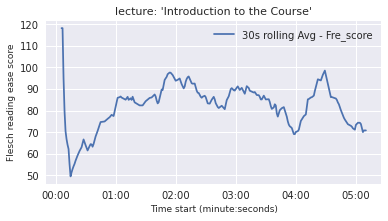

In [6]:
def create_readablity_plot(df, lecture):
    '''
    generate plots for different lectures for fk_score
    '''
    fig, ax = plt.subplots(figsize=(6,3))
    data = df.loc[(df['lecture'] == lecture) & (df['granularity'] =='fragment')]
    resample = data['fk_score'].resample('1S').ffill()
    resample = resample.rolling('30S').mean()
    ax.plot(resample, data = resample, label='30s rolling Avg - Fre_score')
    xfmt = md.DateFormatter('%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xlabel('Time start (minute:seconds)', size=9)
    ax.set_ylabel('Flesch reading ease score', size=9)
    ax.set_title('lecture: ' +"'" + lecture + "'", size=11)
    ax.legend()    
    plt.show()
create_readablity_plot(read_df,lectures[0])

### Readability graph for lecture - 'w1 Manipulating Text with Regular Expression'

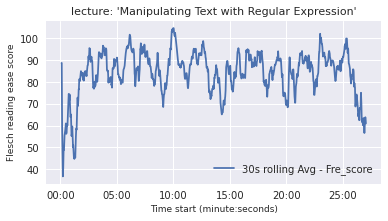

In [7]:
create_readablity_plot(read_df, lectures[1])

### Readability graph for lecture - 'w1 Numerical Python Library (NumPy)'

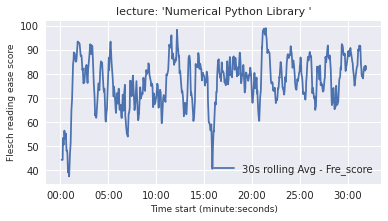

In [8]:
create_readablity_plot(read_df, lectures[2])

### Readability graph for lecture - 'w1 The Coursera Jupyter Notebook System'

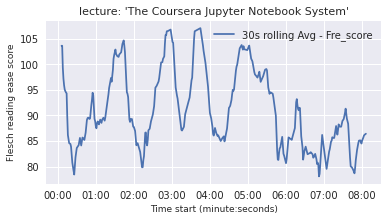

In [9]:
create_readablity_plot(read_df, lectures[3])

### Readability graph for lecture - 'w2 DataFrame Data Structure'

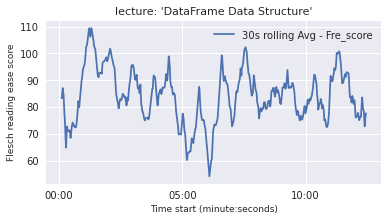

In [10]:
create_readablity_plot(read_df, lectures[4])

### Readability graph for lecture - 'w2 DataFrame Indexing and Loading'

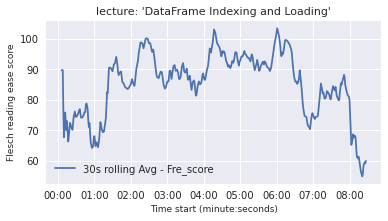

In [11]:
create_readablity_plot(read_df, lectures[5])

### Readability graph for lecture - 'w2 Example Manipulating DataFrame'

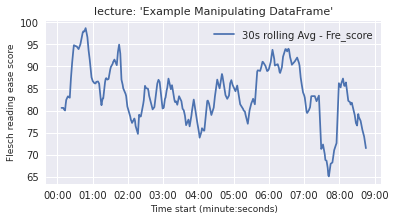

In [12]:
create_readablity_plot(read_df, lectures[6])

### Readability graph for lecture - 'w2 Indexing Dataframes'

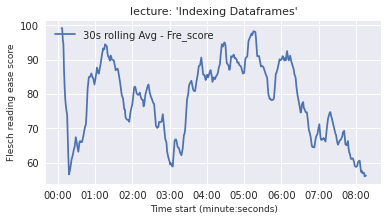

In [13]:
create_readablity_plot(read_df, lectures[7])

### Readability graph for lecture - 'Introduction to the Course'

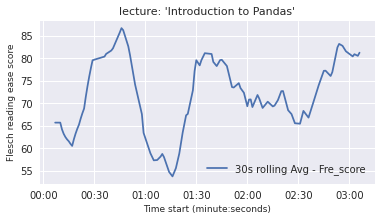

In [14]:
create_readablity_plot(read_df, lectures[8])

### Readability graph for lecture - 'w2 Missing Values'

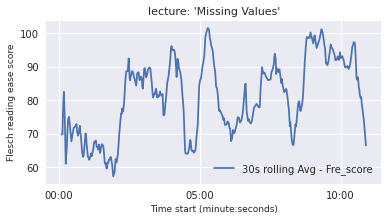

In [15]:
create_readablity_plot(read_df, lectures[9])

### Readability graph for lecture - 'w2 Querying a DataFrame'

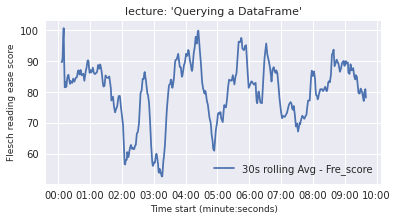

In [16]:
create_readablity_plot(read_df, lectures[10])

### Readability graph for lecture - 'w2 Querying a Series'

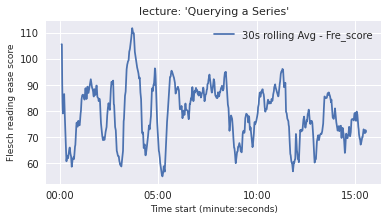

In [17]:
create_readablity_plot(read_df, lectures[11])

### Readability graph for lecture - 'w2 The Series Data Structure'

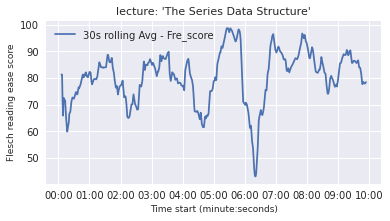

In [18]:
create_readablity_plot(read_df, lectures[12])

### Readability graph for lecture - 'w3 DateTime Functionality'

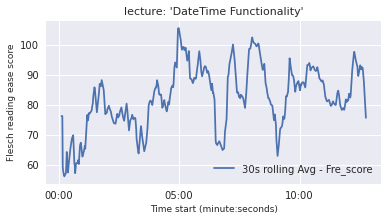

In [19]:
create_readablity_plot(read_df, lectures[13])

### Readability graph for lecture - 'w3 Group by'

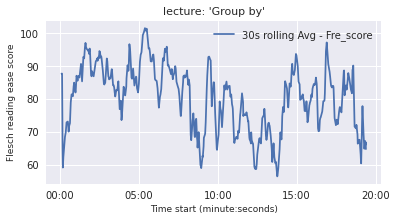

In [20]:
create_readablity_plot(read_df, lectures[14])

### Readability graph for lecture - 'w3 Merging Dataframes'

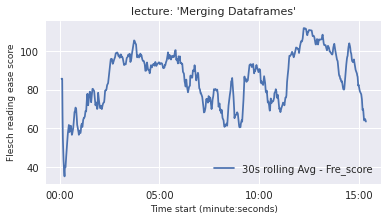

In [21]:
create_readablity_plot(read_df, lectures[15])

### Readability graph for lecture - 'w3 Pandas Idioms'

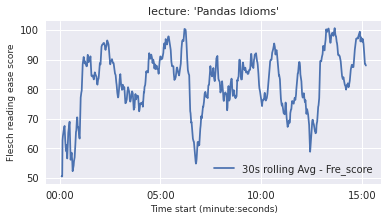

In [22]:
create_readablity_plot(read_df, lectures[16])

### Readability graph for lecture - 'w3 Pivot Table'

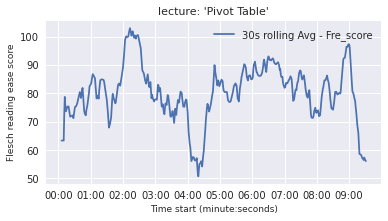

In [23]:
create_readablity_plot(read_df, lectures[17])

### Readability graph for lecture - 'w3 Scales'

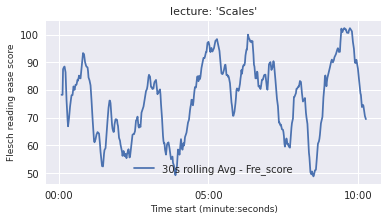

In [24]:
create_readablity_plot(read_df, lectures[18])

### Readability graph for lecture - 'w3 Storing DataFrames (Optional)'

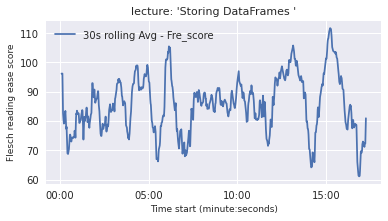

In [25]:
create_readablity_plot(read_df, lectures[19])

### Readability graph for lecture - 'w3 Time Series Data'

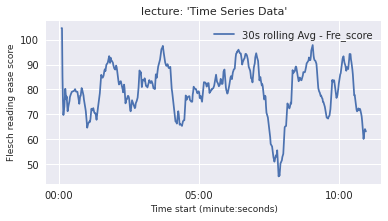

In [26]:
create_readablity_plot(read_df, lectures[20])

### Readability graph for lecture - 'w4 Basic Statistical Testing'

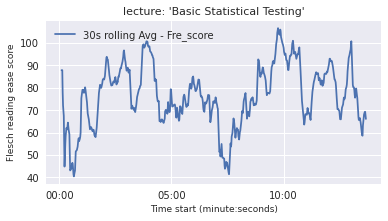

In [27]:
create_readablity_plot(read_df, lectures[21])

### Readability graph for lecture - 'w4 Other Forms of Structured Data'

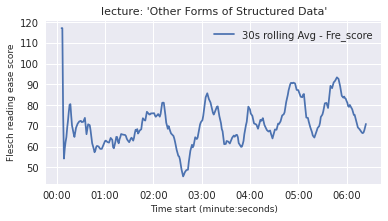

In [28]:
create_readablity_plot(read_df, lectures[22])

### Scale the data - fk_score

In [29]:
# As we can see, fk_score being between 0 and 120 and wide variation in values for different lectures, its difficult to 
# compare readiblity score across different lectures
def create_readablity_plot_norm(df, lecture):
    fig, ax = plt.subplots(figsize=(6,3))
    data = df.loc[(df['lecture'] == lecture) & (df['granularity'] =='fragment')]
    resample = data['fk_score_norm'].resample('1S').ffill()
    resample = resample.rolling('30S').mean()
    ax.plot(resample, data = resample, label='30s rolling Avg - Fre_score')
    xfmt = md.DateFormatter('%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_xlabel('Time start (minute:seconds)', size=9)
    ax.set_ylabel('Flesch reading ease score', size=9)
    ax.set_title('lecture: ' +"'" + lecture + "'", size=11)
    plt.ylim([-2,2])
    ax.legend()
    plt.rcParams['figure.dpi'] = 150
    plt.show()    
    
read_df['fk_score_norm'] = read_df.groupby('granularity').transform(lambda x: (x-x.mean())/x.std())
read_df.head()

,text,time_end,fk_score,granularity,lecture,fk_score_norm
time_start,,,,,,
2021-08-22 00:00:05.180,"Hi. I'm Chris Brooks,",00:00:07.410,118.18,fragment,Introduction to the Course,1.340925
2021-08-22 00:00:07.410,faculty here at the University of,00:00:08.910,48.47,fragment,Introduction to the Course,-1.206239
2021-08-22 00:00:08.910,Michigan School of Information.,00:00:10.920,33.58,fragment,Introduction to the Course,-1.750311
2021-08-22 00:00:10.920,"This class is about data manipulation,",00:00:13.590,48.47,fragment,Introduction to the Course,-1.206239
2021-08-22 00:00:13.590,and data manipulation is really,00:00:15.510,-1.29,fragment,Introduction to the Course,-3.024441


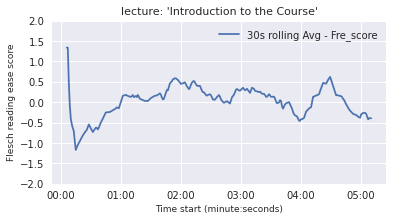

In [30]:
create_readablity_plot_norm(read_df, lectures[0])

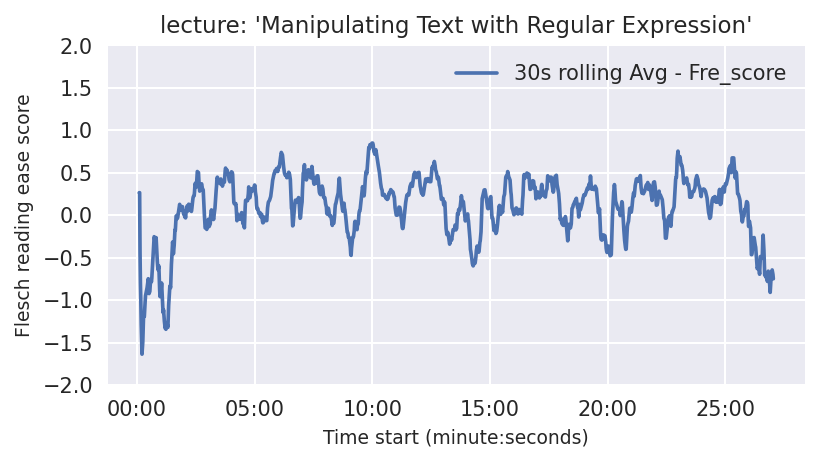

In [31]:
create_readablity_plot_norm(read_df, lectures[1])

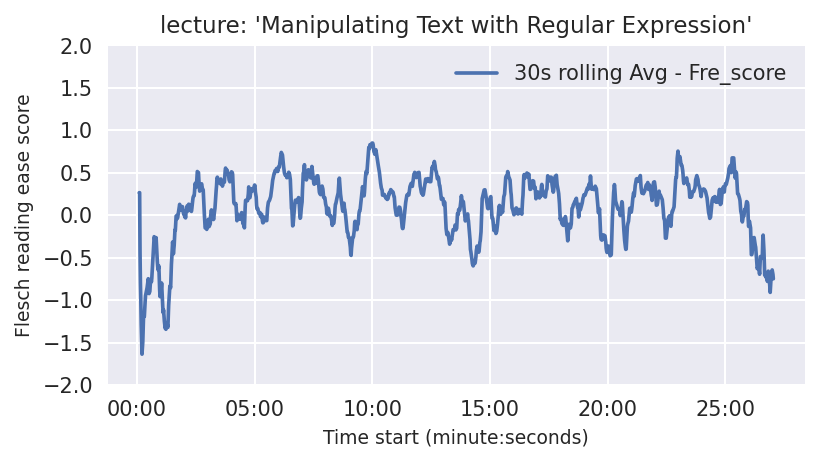

In [32]:
create_readablity_plot_norm(read_df, lectures[1])

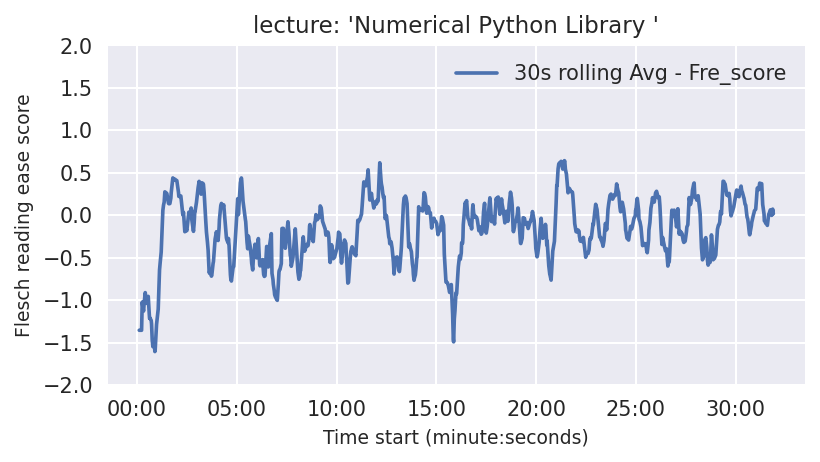

In [33]:
create_readablity_plot_norm(read_df, lectures[2])

In [34]:
# read_df[(read_df['granularity'] == 'lecture')].sort_values

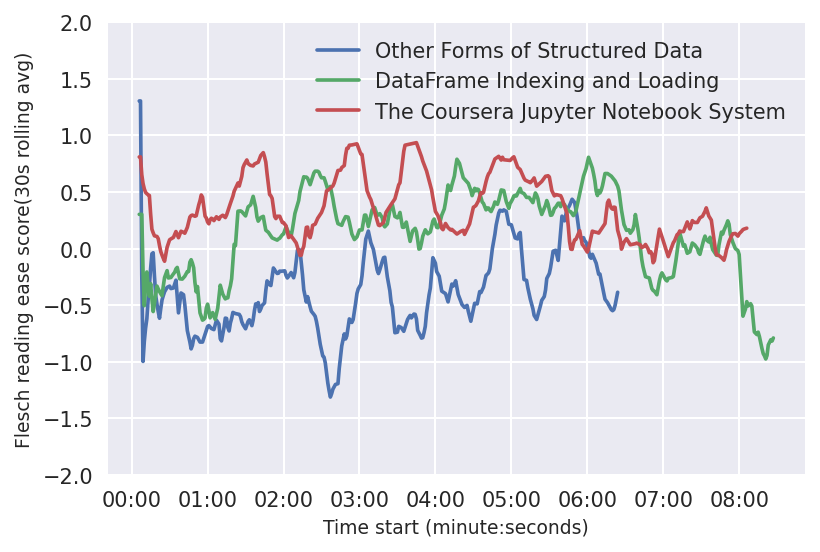

In [35]:
def get_resample_30savg(df, lecture):
    data = df.loc[(df['lecture'] == lecture) & (df['granularity'] =='fragment')]
    resample = data['fk_score_norm'].resample('1S').ffill()
    resample = resample.rolling('30S').mean()
    return(resample)


# Get the lectures in read ease score order - from most readable to least readable
lectures = read_df[read_df['granularity'] == 'lecture'].sort_values(by='fk_score')['lecture'].unique()

resample_0 = get_resample_30savg(read_df, lectures[0])
resample_1 = get_resample_30savg(read_df, lectures[21])    
resample_2 = get_resample_30savg(read_df, lectures[22])  

fig, ax = plt.subplots(figsize=(6,4))
plt.plot(resample_0,  label=lectures[0])
plt.plot(resample_1, label=lectures[21])
plt.plot(resample_2, label=lectures[22])

xfmt = md.DateFormatter('%M:%S')
ax.xaxis.set_major_formatter(xfmt)
ax.set_xlabel('Time start (minute:seconds)', size=9)
ax.set_ylabel('Flesch reading ease score(30s rolling avg)', size=9)
#     ax.set_title('lecture: ' +"'" + lecture + "'")
plt.ylim([-2,2])
ax.legend()
plt.rcParams['figure.dpi'] = 150
plt.show()    

So from the above plot, we can see that course - 
 - Most readble - "Other forms of Structured Data" 
 - least readble - "The Coursera Jupyter Notebook System"

#### Further, we can check few sentences which have negative scores


In [36]:
# Further, we can check few sentences which have negative scores
sentence_df = read_df[read_df['granularity']=='sentence']
sentence_df[sentence_df['fk_score'] < 0].sort_values('fk_score').head().reset_index(drop=True)

,text,time_end,fk_score,granularity,lecture,fk_score_norm
0,Let's get the CGPA column and only the first f...,00:28:20.321,-26.31,sentence,Numerical Python Library,-4.626189
1,They're incredibly powerful.,00:26:40.110,-24.64,sentence,Manipulating Text with Regular Expression,-4.547038
2,"Timestamp, DatetimeIndex, Period, and PeriodIn...",00:00:41.178,-18.21,sentence,DateTime Functionality,-4.242281
3,"From Individual bite representations, through ...",00:15:29.112,-10.42,sentence,Numerical Python Library,-3.873065
4,"So, indexing, slicing and iterating are extrem...",00:15:51.503,-0.95,sentence,Numerical Python Library,-3.424224


In [37]:
# Confirm that we are computing the fk_score correctly for these
text = sentence_df[sentence_df['fk_score'] < 0].sort_values('fk_score').head().reset_index(drop=True)['text'][0] 
print(text)
textstat.flesch_reading_ease(text)

Let's get the CGPA column and only the first five values, so we'll take graduate So, this tells us we only want to get that one column and then we want to get the first five values, so So, since the GPA in the data set range from in the US it's more common to use a scale of to convert the GPA by dividing by So, graduate admission CGPA is equal to the graduate And let's look at the output of like And it's important to keep in mind that we've actually changed now this data, right So, we actually assigned graduate admissions sub CGPA, that changes it on the underlying array.


-26.31

#### Further, we can check few fragments which have negative scores

In [38]:
fragment_df = read_df[read_df['granularity'] == 'fragment']
fragment_df[fragment_df['fk_score'] < 0].sort_values('fk_score').head()

,text,time_end,fk_score,granularity,lecture,fk_score_norm
time_start,,,,,,
2021-08-22 00:06:44.307,"Beside elementwise manipulation,",00:06:46.518,-134.62,fragment,Numerical Python Library,-7.896243
2021-08-22 00:00:27.947,behind experimentation.,00:00:29.910,-133.60,fragment,Basic Statistical Testing,-7.858973
2021-08-22 00:11:27.200,The typical mathematical operations,00:11:29.600,-76.41,fragment,Querying a Series,-5.769283
2021-08-22 00:02:43.040,Pandas can't determine automatically,00:02:45.080,-51.03,fragment,Querying a Series,-4.841912
2021-08-22 00:00:30.990,"using vectorization wherever possible,",00:00:33.050,-51.03,fragment,Pandas Idioms,-4.841912
